In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import quad
from matplotlib import ticker, rcParams

# wrote the E(z) integrations explicitly... 
#  ... maybe could be faster with astropy?
# from astropy import cosmology as cosmo

# MCMC approach abandoned
#import emcee
#import corner

In [2]:
# SR's personal plotting setup function.  Shortcut to replace rcParams settings in next cell
# from pytools import plotsetup
# plotsetup.paperfig()

In [3]:
rcParams['text.usetex'] = True
rcParams['figure.figsize']=[6,4]
rcParams['font.size']=12    # text big enough for a half-page fig
rcParams['axes.labelsize'] = 12      # fontsize of the x and y labels
rcParams['axes.titlesize'] = 12      # fontsize of the axes title
rcParams['xtick.labelsize'] = 12      # fontsize of the x and y labels
rcParams['ytick.labelsize'] = 12      # fontsize of the x and y labels
rcParams['lines.linewidth']=1.5
rcParams['lines.color']='k'     # thicker black lines 
rcParams['lines.markersize']=6
rcParams['lines.markeredgewidth']=1.     # big fat points
rcParams['axes.linewidth']=1.
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['xtick.major.width'] = 1.5      # major tick thickness in points
rcParams['xtick.minor.width'] = 1.2      # major tick thickness in points
rcParams['xtick.major.size'] = 6      # major tick size in points
rcParams['xtick.minor.size'] = 4      # minor tick size in points
rcParams['xtick.major.pad'] = 5      # distance to major tick label in points
rcParams['xtick.minor.pad'] = 5      # distance to the minor tick label in points
rcParams['ytick.major.width'] = 1.5      # major tick thickness in points
rcParams['ytick.minor.width'] = 1.2      # major tick thickness in points
rcParams['ytick.major.size'] = 6      # major tick size in points
rcParams['ytick.minor.size'] = 4      # minor tick size in points
rcParams['ytick.major.pad'] = 5      # distance to major tick label in points
rcParams['ytick.minor.pad'] = 5      # distance to the minor tick label in points
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [4]:
# Define the "true" cosmology: flat w0waCDM
# Om0 = 0.3
# Ode0 = 0.7
# w0true=-1.
# watrue=0.
#H0=70    # this is puzzling: C&M09 show H0 dependence in their contours, but I don't see how...
# cosmo_true = cosmo.w0waCDM(H0=H0, Om0=Om0, Ode0=Ode0, w0=w0true, wa=watrue)

## Cosmology Functions 
for computing the normalized hubble parameter E(z) = H(z)/H0 and ratios thereof

In [5]:
def EA(z1, z2, Om0, w0, wa):
    """The integral of the inverse of the normalized 
    Hubble parameter, from z1 to z2:  int_z1^z2{1/E(z')dz}
    Eq 8 of Coe & Moustakas 2009.
    Assuming a flat universe."""
    
    Ode0 = 1-Om0 # assuming flat universe
    #if w0>-0.3 or w0<-2:
    #    result = -np.inf
    #elif np.abs(wa)>5:
    #    result = -np.inf
    #else:
    Ez2 = lambda z: ( Om0*(1+z)**3 + 
                     Ode0*(1+z)**(3*(1+w0+wa)) * 
                     np.exp(-3*wa*z/(1+z)) )
    Ezinv = lambda z: 1 / np.sqrt(Ez2(z))
    # if Ez2(z1)>0 and Ez2(z2)>0:
    result, precision = quad(Ezinv, z1, z2)
    #else:
    #    result = -np.inf
    return(result)

In [6]:
def Eratio(zl, zs, Om0, w0, wa):
    """The time delay expansion function ratio 
    (script E, eq 12 in Coe & Moustakas 2009).
    Assuming a flat universe."""
    EL = EA(0,zl, Om0, w0, wa)
    ES = EA(0,zs, Om0, w0, wa)
    ELS = EA(zl, zs, Om0, w0, wa)

    #if EL<=0 or ES<=0 or ELS<=0:
    #    Erat = -np.inf
    #else:
    Erat = EL * ES / ELS
    return(Erat)

In [7]:
def Evariance(Erat, dTc):
    """The variance on the E ratio due to the 
    time delay and lens potential uncertainty. 
    dTc : percent uncertainty on time delay distance ratio 
        (combining time delay measurement + lens modeling error)  
        (This is a percentage:  enter "5" for 5% precision)
    """
    return( Erat**2 * (dTc/100.)**2 )


def loglikelihoodE(w0wa, zl, zs, dTc=0.1, 
                   Om0=0.3, w0true=-1., watrue=0.): 
    """log10(likelihood) for a time delay distance 
    ratio constraint, comparing 
    a given test point in w0,wa space to the true (w0,wa) position. 
    
    w0wa: [w0,wa], the test point
    zl : lens redshift
    zs : source redshift
    dTc : percent precision on cosmological distance ratio, combining
       uncertainty from the time delay measurement + lens modeling
    Om0, w0true, watrue : the true cosmology
    """
    #Note: the Eratio function assumes a flat universe
    Eratio_true = Eratio(zl, zs, Om0, w0true, watrue)
    Eratio_w0wa = Eratio(zl, zs, Om0, w0wa[0], w0wa[1])

    #if np.isfinite(Eratio_w0wa):
    loglike = -0.5 * ( (Eratio_true-Eratio_w0wa)**2 / 
                      Evariance(Eratio_w0wa, dTc))
    #else:
    #    loglike = -np.inf
    return(loglike)


In [8]:
# This function is for turning the likelihood arrays into contours
from copy import deepcopy
def rescale_likelihood( a ):
    """
    Rescale the likelihood array using 
    a Sorted Cumulative Sum function (e.g., for making contours)
    Construct an array "sumabove" such that the cell 
    at index i in sumabove is equal to the sum of all 
    cells from the input array "a" that have a
    cell value higher than a[i]
    """
    # Collapse the array into 1 dimension
    sumabove = deepcopy(a).ravel()

    # Sort the raveled array by descending cell value
    iravelsorted = sumabove.argsort( axis=0 )[::-1]

    # Reassign each cell to be the cumulative sum of all
    # input array cells with a higher value :
    sumabove[iravelsorted] = sumabove[iravelsorted].cumsum()

    # Normalize by the max value in the array
    sumabove /= sumabove.max()

    # Now unravel back into shape of original array and return
    return( sumabove.reshape( a.shape ) )

### A couple of test cells
just for checking our work, Safe to skip / ignore (hence the 'if False')

In [9]:
# Check that the E(z) functions are working. Should give different curves
# for different lens redshifts
w0true = -1
watrue = 0

if False: 
    for z1 in [0.3, 0.7, 1.0]:
        z = np.arange(0, 2., 0.1)
        EAz = np.array([EA(z1, z2, Om0, Ode0, w0true, watrue) for z2 in z])
        plt.plot(z, EAz, ls='-', label='{:.1f}'.format(z1))

In [10]:
if False:
    # Check that the log(Likelihood) function is working.  Should give 
    # different curves at different fixed wa, slicing across
    # the 'boomerang' from CM09 fig 10
    walist = np.arange(-3, 3, 0.5)
    w0list = np.arange(-2,0,0.05)
    for wa in walist:
        loglE = np.array([loglikelihoodE([w0, wa], zl_req, zs_req) for w0 in w0list])
        plt.plot(w0list, loglE, label='wa={:.1f}'.format(wa))
        plt.legend(loc='lower right')

## Define the time delay precision from each survey

Following Coe and Moustakas 2009 (see their Eq 10 and Fig 10) but adopting more recent predictions for the yield of multiply-imaged SNIa with good time delays from LSST (Huber+ 2019).   Note that all the uncertainties $\delta T_L$, $\delta T_T$ and $\delta T_C$ are given as percentages.   So dTL = 5 means a 5% uncertainty on the time delay distance ration due to lens modeling uncertainty.

In [12]:
# LSST good time delays (following Huber+ 2019)
lsst = {
    'N':10,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':0.3, 'zs':0.8 # lens and source redshift
}

# WFIRST : OM10 and Oguri (private communication)
wfirst = {
    'N':10,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':3,  # % time delay measurement uncertainty for each
    'zl':0.8, 'zs':2.0 # lens and source redshift
}
    
requiem = {
    'N':1,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':0.338, 'zs':1.95 # lens and source redshift
}

# 2% uncertainty
requiem_better = {
    'N':1,   # number of Lensed SNe Ia with good time delays
    'dTL':2,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':0.338, 'zs':1.95 # lens and source redshift
}


# For each survey, compute the net uncertainty on cosmological parameters
# from time delays
# (using a shortcut by just adding in quadrature and scaling by root N)
for survey in [lsst, wfirst, requiem, requiem_better]:
    dTL = survey['dTL']
    dTT = survey['dTT']
    N = survey['N']
    survey['dTc'] = np.sqrt(dTL**2 + dTT**2) / np.sqrt(N)
    

In [13]:
class Survey(object):
    def __init__(self, N=10, dTL=5, dTT=5, zl=0.3, zs=0.8, name='LSST', **kwargs):
        self.N = N
        self.dTL = dTL
        self.dTT = dTT
        self.zl = zl
        self.zs = zs
        self.likelihood = None
    
    @property
    def dTc(self):
        return np.sqrt(self.dTL**2 + self.dTT**2) / np.sqrt(self.N)   
    
    def compute_likelihood(self, w0list, walist):
        loglE = np.array([[loglikelihoodE([w0, wa], self.zl, self.zs, self.dTc)
                            for wo in w0list] 
                              for wa in walist])
        
        likelihood = 10**loglE
        like_rescaled = rescale_likelihood(likelihood)
        self.likelihood = like_rescaled
    
LSST = Survey(**lsst)
print(LSST.dTc, lsst['dTc'])

2.23606797749979 2.23606797749979


## Compute the likelihood in w0, wa space
Note that we are assuming perfect knowledge of H0 and Om, and assuming a flat universe. (Perhaps an optimistic view of the state of cosmology in 2035, but the purpose here is to show the constraining power of SN Requiem and how it is complementary to most of the lensed SN samples we expect from LSST and WFIRST.

In [27]:
# No MCMC here, just make a simple grid of w0, wa and compute the likelihood at each point
w0list = np.arange(-1.4, -0.3, 0.01)
walist = np.arange(-3, 3, 0.04)
w0grid, wagrid = np.meshgrid(w0list, walist) 

for survey in [lsst, requiem, wfirst, requiem_better]:
    loglE = np.array([[loglikelihoodE([
        w0list[i], walist[j]], 
        survey['zl'], survey['zs'], survey['dTc'])
                       for i in range(len(w0list))] 
                      for j in range(len(walist))])
    likelihood = np.exp(loglE)
    like_rescaled = rescale_likelihood(likelihood)
    survey['likelihood'] = like_rescaled
    

## Plot the 1-sigma (68%) contours

In [64]:
from grizli import utils
print(utils.MPL_COLORS['orange'])
print(utils.MPL_COLORS)

#ff7f0e
{'b': '#1f77b4', 'orange': '#ff7f0e', 'g': '#2ca02c', 'r': '#d62728', 'purple': '#9467bd', 'brown': '#8c564b', 'pink': '#e377c2', 'gray': '#7f7f7f', 'olive': '#bcbd22', 'cyan': '#17becf'}


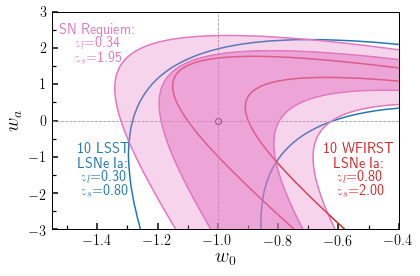

In [29]:
# To make sure we didn't switch up the input grids
# and fail to re-run the likelihood calculation, lets 
# require that the shapes agree
assert(w0grid.shape == wagrid.shape)
assert(wagrid.shape == loglE.shape)

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1)

rc = '#e377c2' # pink
other_colors = ['#1f77b4',  '#d62728'] # b, r

for survey, color, alpha in zip([lsst, requiem, requiem_better, wfirst],
                         [other_colors[0], rc, rc, other_colors[1]],
                         [0.3, 0.3, 0.5, 0.3]):
    
    ax.contour(w0grid, wagrid, survey['likelihood'], colors=[color],
               levels=[0,0.68])
    if color == rc:
        ax.contourf(w0grid, wagrid, survey['likelihood'], colors=[color],
                    levels=[0,0.68], alpha=alpha, zorder=10)

ax.plot(-1,0,marker='o', mec='k', mfc='w', ms=6)
ax.axhline(0,ls='--', color='0.6', lw=0.8)
ax.axvline(-1,ls='--', color='0.6', lw=0.8)

ax.set_xlabel("$w_0$", fontsize=20)
ax.set_ylabel("$w_a$", fontsize=20)

plt.setp(ax.xaxis.get_ticklabels(), fontsize='large')
plt.setp(ax.yaxis.get_ticklabels(), fontsize='large')

ax.text(-1.4,1.5,"SN Requiem:\n$z_l$={:.2f}\n$z_s$={:.2f}".format(
    requiem['zl'],requiem['zs']), color=rc, ha='center', va='bottom', fontsize='large')

ax.text(-1.38,-1.4,"{:d} LSST\nLSNe Ia:\n$z_l$={:.2f}\n$z_s$={:.2f}".format(
    lsst['N'], lsst['zl'],lsst['zs']), 
        color=other_colors[0], ha='center',va='center', fontsize='large')

ax.text(-0.53,-1.4,"{:d} WFIRST\nLSNe Ia:\n$z_l$={:.2f}\n$z_s$={:.2f}".format(
    wfirst['N'],wfirst['zl'],wfirst['zs']), 
        color=other_colors[1], ha='center',va='center', fontsize='large')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.set_xlim(-1.55,-0.4)
ax.set_ylim(-3,3)

plt.tight_layout()

plt.savefig("../../Paper/Figures/snrequiem_w0wa_compared_to_lsst_wfirst.pdf")

# The remainder of this is not really needed

kept here for posterity

### TESTING the contour plotting with a 2-D Gaussian

In [ ]:
# define a 2-D gaussian
from scipy.stats import multivariate_normal

# Our 2-dimensional distribution will be over variables w0 and wa
# Pack w0 and wa into a single 3-dimensional array
pos = np.empty(w0grid.shape + (2,))
pos[:, :, 0] = w0grid
pos[:, :, 1] = wagrid

# Mean vector and covariance matrix
mu = np.array([-1., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

F = multivariate_normal(mu, Sigma)
Z = F.pdf(pos)

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(1,1,1)

plt.imshow(Z, aspect='auto', origin='bottom', extent=[-2,-0.3,-3,3], interpolation='nearest')
plt.colorbar()

Z /= Z.sum()
Zscaled = (Z-Z.min())/(Z.max()-Z.min())
#Zscaled = (Z)/(Z.sum())
ax.contour(w0grid, wagrid, Zscaled, colors=['m','k','r'], levels=[0.68,0.84, 0.95])
#ax.contour(w0grid, wagrid, Z, colors=['m','k','r'], levels=[0.68,0.84, 0.95])

print(Z.sum())
print(Zscaled.sum())

# Alternate likelihood calc: using MCMC
(This is not working, and I don't know why)

In [ ]:
# Set up the emcee Ensemble Sampler for SN Requiem

snReqparams = [zl_req, zs_req, dtpct_req, dphipct_req, Om0, Ode0, w0true, watrue]
nwalkers=64
ndim=2
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikelihoodE, 
                                args=snReqparams)

# and an array of initial positions for the walkers
w0wa_init = np.random.random(size=(nwalkers,ndim))
w0wa_init[:,0] = w0wa_init[:,0] * -2
w0wa_init[:,1] = w0wa_init[:,1] * -6 + 3

In [ ]:
# check that the initial positions of the walkers are 
# sampling the w0,wa space as we expect
plt.scatter(w0wa_init[:,0], w0wa_init[:,1]) 

In [ ]:
# Run the sampler with a 'burn-in' series of 200 steps
state = sampler.run_mcmc(w0wa_init, 200)
sampler.reset()

In [ ]:
# Do the 'production run' starting from the end-point of the burn-in state
final_state = sampler.run_mcmc(state, 10000)

In [ ]:
# scatter plot of the sampling chain:
samples = sampler.get_chain(flat=True)
plt.plot(samples[:,0], samples[:,1], marker='.', ls=' ', alpha=0.3)
ax = plt.gca()
ax.set_xlim(-2, 0)
ax.set_ylim(-3, 3)

In [ ]:
# Make a corner plot
samples = sampler.get_chain(flat=True)
figure = corner.corner(samples)